In [3]:
!pip install -q openpyxl joblib


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from datetime import timedelta

def savefig(fig, path, dpi=150):
    fig.savefig(path, bbox_inches='tight', dpi=dpi)


In [5]:

from google.colab import files
print("Upload the Excel file (Customer_Churn_Data_Large.xlsx) when prompted:")
uploaded = files.upload()
FILE_PATH = list(uploaded.keys())[0]


print("Using file:", FILE_PATH)


Upload the Excel file (Customer_Churn_Data_Large.xlsx) when prompted:


Saving Customer_Churn_Data_Large.xlsx to Customer_Churn_Data_Large.xlsx
Using file: Customer_Churn_Data_Large.xlsx


In [6]:

xls = pd.ExcelFile(FILE_PATH)
print("Sheets found:", xls.sheet_names)

dem = pd.read_excel(xls, sheet_name="Customer_Demographics")
txn = pd.read_excel(xls, sheet_name="Transaction_History")
cs = pd.read_excel(xls, sheet_name="Customer_Service")
online = pd.read_excel(xls, sheet_name="Online_Activity")
churn = pd.read_excel(xls, sheet_name="Churn_Status")

print("\nShapes:")
print("demographics:", dem.shape)
print("transactions:", txn.shape)
print("customer_service:", cs.shape)
print("online_activity:", online.shape)
print("churn_status:", churn.shape)

print("\nDemo columns:", dem.columns.tolist())
print("Txn columns:", txn.columns.tolist())
print("CS columns:", cs.columns.tolist())
print("Online columns:", online.columns.tolist())
print("Churn columns:", churn.columns.tolist())

display(dem.head())
display(txn.head())
display(cs.head())
display(online.head())
display(churn.head())


Sheets found: ['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status']

Shapes:
demographics: (1000, 5)
transactions: (5054, 5)
customer_service: (1002, 5)
online_activity: (1000, 4)
churn_status: (1000, 2)

Demo columns: ['CustomerID', 'Age', 'Gender', 'MaritalStatus', 'IncomeLevel']
Txn columns: ['CustomerID', 'TransactionID', 'TransactionDate', 'AmountSpent', 'ProductCategory']
CS columns: ['CustomerID', 'InteractionID', 'InteractionDate', 'InteractionType', 'ResolutionStatus']
Online columns: ['CustomerID', 'LastLoginDate', 'LoginFrequency', 'ServiceUsage']
Churn columns: ['CustomerID', 'ChurnStatus']


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low
1,2,65,M,Married,Low
2,3,18,M,Single,Low
3,4,21,M,Widowed,Low
4,5,21,M,Divorced,Medium


,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory
0,1,7194,2022-03-27,416.50,Electronics
1,2,7250,2022-08-08,54.96,Clothing
2,2,9660,2022-07-25,197.50,Electronics
3,2,2998,2022-01-25,101.31,Furniture
4,2,1228,2022-07-24,397.37,Clothing


,CustomerID,InteractionID,InteractionDate,InteractionType,ResolutionStatus
0,1,6363,2022-03-31,Inquiry,Resolved
1,2,3329,2022-03-17,Inquiry,Resolved
2,3,9976,2022-08-24,Inquiry,Resolved
3,4,7354,2022-11-18,Inquiry,Resolved
4,4,5393,2022-07-03,Inquiry,Unresolved


,CustomerID,LastLoginDate,LoginFrequency,ServiceUsage
0,1,2023-10-21,34,Mobile App
1,2,2023-12-05,5,Website
2,3,2023-11-15,3,Website
3,4,2023-08-25,2,Website
4,5,2023-10-27,41,Website


,CustomerID,ChurnStatus
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [7]:

def lc_cols(df):
    df.columns = [c.strip() for c in df.columns]
    return df

dem = lc_cols(dem)
txn = lc_cols(txn)
cs  = lc_cols(cs)
online = lc_cols(online)
churn = lc_cols(churn)

# Ensure expected key names exist
print("Keys present?:",
      "customer_id" in dem.columns,
      "customer_id" in txn.columns,
      "customer_id" in cs.columns,
      "customer_id" in online.columns,
      "customer_id" in churn.columns)


Keys present?: False False False False False


In [8]:

txn['TransactionDate'] = pd.to_datetime(txn['TransactionDate'], errors='coerce')
cs['InteractionDate'] = pd.to_datetime(cs['InteractionDate'], errors='coerce')
online['LastLoginDate'] = pd.to_datetime(online['LastLoginDate'], errors='coerce')

print("Transaction date range:", txn['TransactionDate'].min(), "→", txn['TransactionDate'].max())
print("Interaction date range:", cs['InteractionDate'].min(), "→", cs['InteractionDate'].max())
print("Last login date range:", online['LastLoginDate'].min(), "→", online['LastLoginDate'].max())


Transaction date range: 2022-01-01 00:00:00 → 2022-12-31 00:00:00
Interaction date range: 2022-01-01 00:00:00 → 2022-12-30 00:00:00
Last login date range: 2023-01-01 00:00:00 → 2023-12-31 00:00:00


In [9]:

print("Demographics columns:", dem.columns.tolist())
print("Transaction columns:", txn.columns.tolist())
print("Customer Service columns:", cs.columns.tolist())
print("Online columns:", online.columns.tolist())
print("Churn columns:", churn.columns.tolist())

def clean_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

dem = clean_columns(dem)
txn = clean_columns(txn)
cs = clean_columns(cs)
online = clean_columns(online)
churn = clean_columns(churn)

rename_map = {}
for df in [dem, txn, cs, online, churn]:
    for col in df.columns:
        if col in ['customerid', 'cust_id', 'id']:
            rename_map[col] = 'customer_id'
    df.rename(columns=rename_map, inplace=True)

for name, df in [('dem', dem), ('txn', txn), ('cs', cs), ('online', online), ('churn', churn)]:
    if 'customer_id' not in df.columns:
        raise ValueError(f"'customer_id' column missing in {name} after cleaning!")

df = dem.merge(txn, on="customer_id", how="left") \
        .merge(cs, on="customer_id", how="left") \
        .merge(online, on="customer_id", how="left") \
        .merge(churn, on="customer_id", how="left")

print("Merged dataset shape:", df.shape)
df.head()


Demographics columns: ['CustomerID', 'Age', 'Gender', 'MaritalStatus', 'IncomeLevel']
Transaction columns: ['CustomerID', 'TransactionID', 'TransactionDate', 'AmountSpent', 'ProductCategory']
Customer Service columns: ['CustomerID', 'InteractionID', 'InteractionDate', 'InteractionType', 'ResolutionStatus']
Online columns: ['CustomerID', 'LastLoginDate', 'LoginFrequency', 'ServiceUsage']
Churn columns: ['CustomerID', 'ChurnStatus']
Merged dataset shape: (6812, 17)


,customer_id,age,gender,maritalstatus,incomelevel,transactionid,transactiondate,amountspent,productcategory,interactionid,interactiondate,interactiontype,resolutionstatus,lastlogindate,loginfrequency,serviceusage,churnstatus
0,1,62,M,Single,Low,7194,2022-03-27,416.50,Electronics,6363.0,2022-03-31,Inquiry,Resolved,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,7250,2022-08-08,54.96,Clothing,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
2,2,65,M,Married,Low,9660,2022-07-25,197.50,Electronics,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
3,2,65,M,Married,Low,2998,2022-01-25,101.31,Furniture,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
4,2,65,M,Married,Low,1228,2022-07-24,397.37,Clothing,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1


In [10]:
print(df.columns[df.columns.str.contains('churn', case=False)])


Index(['churnstatus'], dtype='object')


Summary statistics for numeric features:


,customer_id,age,transactionid,transactiondate,amountspent,interactionid,interactiondate,lastlogindate,loginfrequency,churnstatus
count,6812.000000,6812.000000,6812.000000,6812,6812.000000,5204.000000,5204,6812,6812.000000,6812.000000
mean,500.169260,43.274516,5497.323253,2022-07-01 02:11:29.136817408,251.620527,5921.861261,2022-07-01 16:31:10.561106944,2023-07-06 04:56:47.633587712,25.724310,0.198473
min,1.000000,18.000000,1000.000000,2022-01-01 00:00:00,5.180000,2015.000000,2022-01-01 00:00:00,2023-01-01 00:00:00,1.000000,0.000000
25%,247.000000,30.000000,3223.500000,2022-04-02 00:00:00,127.100000,3873.250000,2022-04-07 00:00:00,2023-04-12 00:00:00,14.000000,0.000000
50%,505.500000,44.000000,5515.000000,2022-07-01 00:00:00,251.845000,5903.000000,2022-07-02 00:00:00,2023-07-13 00:00:00,26.000000,0.000000
75%,750.000000,56.000000,7675.250000,2022-09-30 00:00:00,375.280000,7851.000000,2022-09-25 00:00:00,2023-10-01 00:00:00,38.000000,0.000000
max,1000.000000,69.000000,9997.000000,2022-12-31 00:00:00,499.860000,9997.000000,2022-12-30 00:00:00,2023-12-31 00:00:00,49.000000,1.000000
std,286.704642,15.286788,2584.768541,NaN,142.901693,2332.331260,NaN,NaN,14.062032,0.398880



Churn value counts (column: churnstatus):
churnstatus
0    5460
1    1352
Name: count, dtype: int64

Churn percentage (column: churnstatus):
churnstatus
0    80.152672
1    19.847328
Name: proportion, dtype: float64


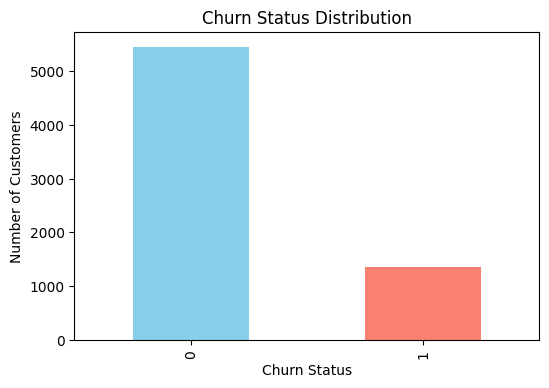

In [11]:
churn_col = [col for col in df.columns if 'churn' in col.lower()]
if len(churn_col) == 1:
    churn_col = churn_col[0]
else:
    raise ValueError("Ambiguous churn column name, please check.")

print("Summary statistics for numeric features:")
display(df.describe())

print(f"\nChurn value counts (column: {churn_col}):")
print(df[churn_col].value_counts())
print(f"\nChurn percentage (column: {churn_col}):")
print(df[churn_col].value_counts(normalize=True) * 100)

fig, ax = plt.subplots(figsize=(6,4))
df[churn_col].value_counts().plot(kind='bar', ax=ax, color=['skyblue','salmon'])
ax.set_title("Churn Status Distribution")
ax.set_xlabel("Churn Status")
ax.set_ylabel("Number of Customers")
plt.show()


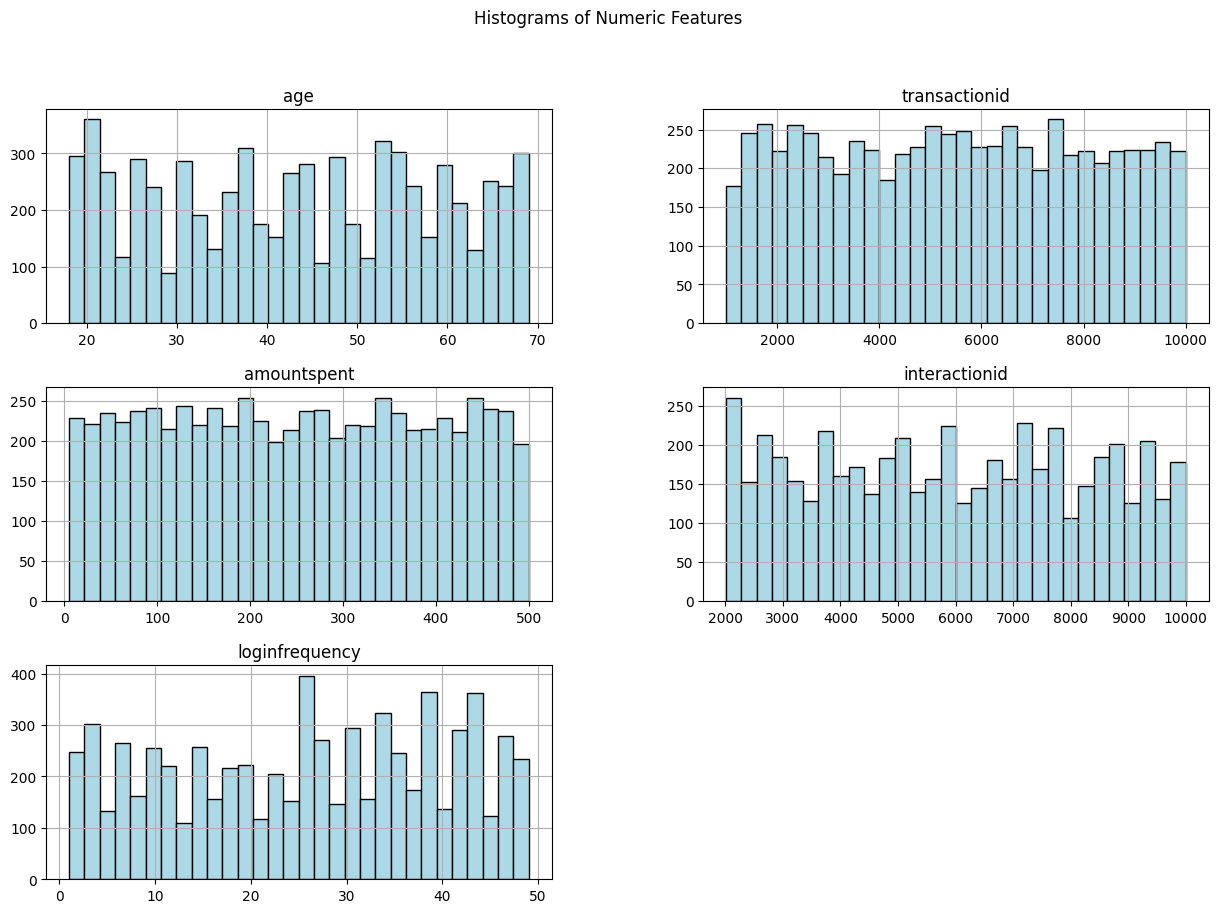

In [12]:

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'customer_id' and col != churn_col]

df[numeric_cols].hist(bins=30, figsize=(15,10), color='lightblue', edgecolor='black')
plt.suptitle("Histograms of Numeric Features")
plt.show()


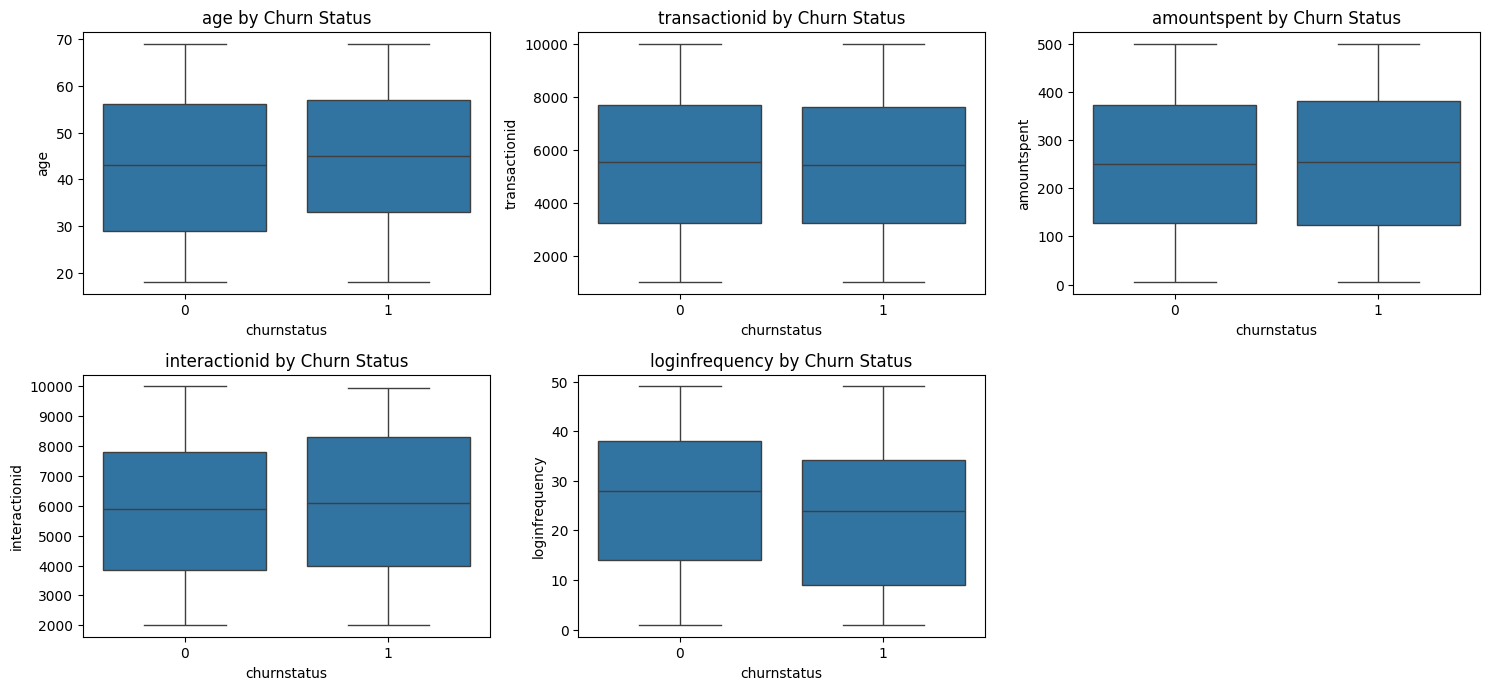

In [13]:

import seaborn as sns

plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[churn_col], y=df[col])
    plt.title(f"{col} by Churn Status")
    plt.tight_layout()
plt.show()


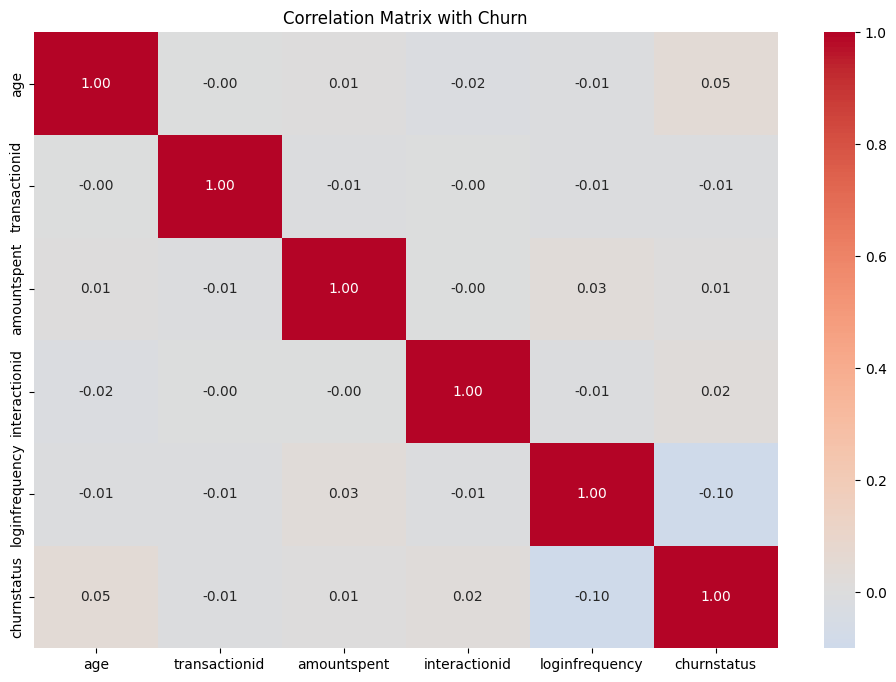

In [14]:

corr = df[numeric_cols + [churn_col]].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title("Correlation Matrix with Churn")
plt.show()


Missing value percentages by column:
interactionid       23.605402
interactiondate     23.605402
interactiontype     23.605402
resolutionstatus    23.605402
dtype: float64


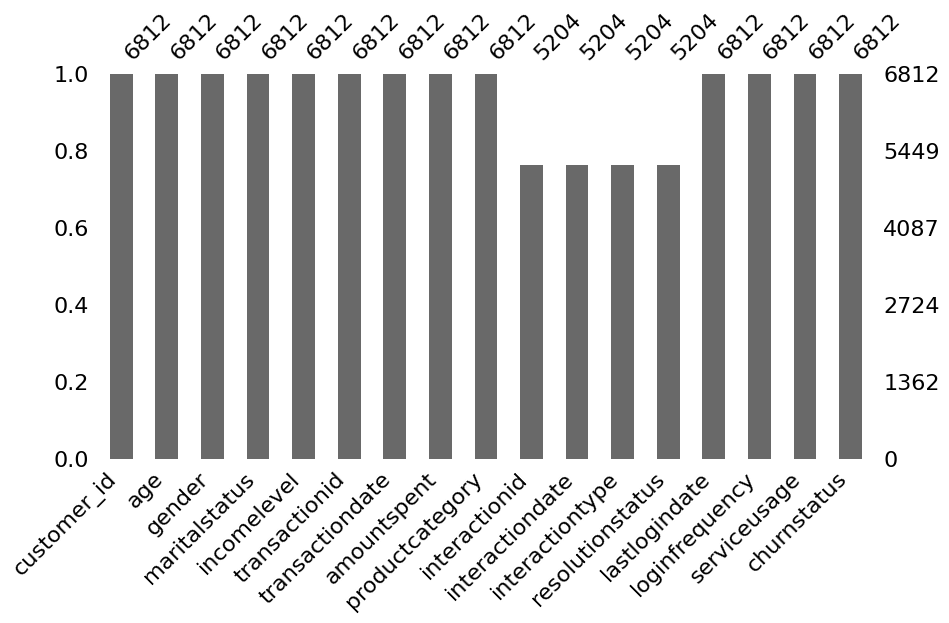

In [15]:

missing = df.isnull().mean() * 100
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing value percentages by column:")
print(missing)

import missingno as msno
msno.bar(df, figsize=(10,5))
plt.show()


In [16]:


num_cols_with_na = [col for col in numeric_cols if df[col].isnull().any()]
for col in num_cols_with_na:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols_with_na = [col for col in cat_cols if df[col].isnull().any()]
for col in cat_cols_with_na:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)

print("Missing values after imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Missing values after imputation:
interactiondate    1608
dtype: int64


/tmp/ipython-input-1404133878.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/tmp/ipython-input-1404133878.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [17]:

def cap_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

for col in numeric_cols:
    df[col] = cap_outliers(df[col])

print("Outliers capped using IQR method.")


Outliers capped using IQR method.


In [18]:

if 'transactiondate' in df.columns:
    latest_date = df['transactiondate'].max()
    df['recency_days'] = (latest_date - df['transactiondate']).dt.days
    print("Recency feature created.")
else:
    print("'transactiondate' column not found for recency calculation.")


Recency feature created.


In [19]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_features_to_scale = [col for col in numeric_cols if col != churn_col]
df[num_features_to_scale] = scaler.fit_transform(df[num_features_to_scale])

joblib.dump(scaler, 'scaler.joblib')
print("Numeric features standardized.")


Numeric features standardized.


In [20]:

cat_features = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

print(f"One-hot encoded categorical features: {cat_features}")
print("Final dataframe shape:", df.shape)


One-hot encoded categorical features: ['gender', 'maritalstatus', 'incomelevel', 'productcategory', 'interactiontype', 'resolutionstatus', 'serviceusage']
Final dataframe shape: (6812, 26)


In [21]:

print("Checking for duplicate customer_id entries:")
duplicates = df['customer_id'].duplicated().sum()
print(f"Duplicates found: {duplicates}")

print("\nFinal churn distribution:")
print(df[churn_col].value_counts())


Checking for duplicate customer_id entries:
Duplicates found: 5812

Final churn distribution:
churnstatus
0    5460
1    1352
Name: count, dtype: int64


In [22]:

df.to_csv("customer_churn_cleaned.csv", index=False)
print("Cleaned and preprocessed dataset saved as 'customer_churn_cleaned.csv'")


Cleaned and preprocessed dataset saved as 'customer_churn_cleaned.csv'


In [23]:

df_cleaned = pd.read_csv("customer_churn_cleaned.csv")
print("Cleaned dataset loaded. Shape:", df_cleaned.shape)


Cleaned dataset loaded. Shape: (6812, 26)


In [24]:

print("Data cleaning and preprocessing complete.")
print("Dataset shape:", df.shape)
print("Ready for feature selection, model training, and evaluation.")

# Next steps might include:
# - Feature selection
# - Train/test split
# - Model building and tuning


Data cleaning and preprocessing complete.
Dataset shape: (6812, 26)
Ready for feature selection, model training, and evaluation.


In [25]:
!pip install -q xgboost shap imbalanced-learn optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.9 MB/s eta 0:00:00


In [26]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [27]:
churn_col = [c for c in df.columns if 'churn' in c.lower()]
if len(churn_col) != 1:
    raise ValueError("Ambiguous churn column")
churn_col = churn_col[0]
X = df.drop(columns=[churn_col,'customer_id'])
y = df[churn_col].astype(int)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)


In [28]:
sm = SMOTE(random_state=42)

# Identify and remove datetime columns from X_train
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns
X_train_numeric = X_train.drop(columns=datetime_cols)


X_res,y_res = sm.fit_resample(X_train_numeric,y_train)

In [29]:
rf = RandomForestClassifier(random_state=42,n_jobs=-1)
param_grid_rf = {'n_estimators':[200,500],'max_depth':[6,12],'min_samples_split':[2,8]}
gs_rf = GridSearchCV(rf,param_grid_rf,cv=StratifiedKFold(n_splits=5),scoring='roc_auc',n_jobs=-1,verbose=1)
gs_rf.fit(X_res,y_res)
best_rf = gs_rf.best_estimator_
joblib.dump(gs_rf,'rf_gridsearch.joblib')


Fitting 5 folds for each of 8 candidates, totalling 40 fits


['rf_gridsearch.joblib']

In [30]:
X_test_numeric = X_test.drop(columns=datetime_cols)
rf_pred = best_rf.predict(X_test_numeric)
rf_proba = best_rf.predict_proba(X_test_numeric)[:,1]
print(classification_report(y_test,rf_pred))
print("ROC-AUC:",roc_auc_score(y_test,rf_proba))


              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1092
           1       0.86      0.70      0.78       271

    accuracy                           0.92      1363
   macro avg       0.90      0.84      0.86      1363
weighted avg       0.92      0.92      0.92      1363

ROC-AUC: 0.95570941973156


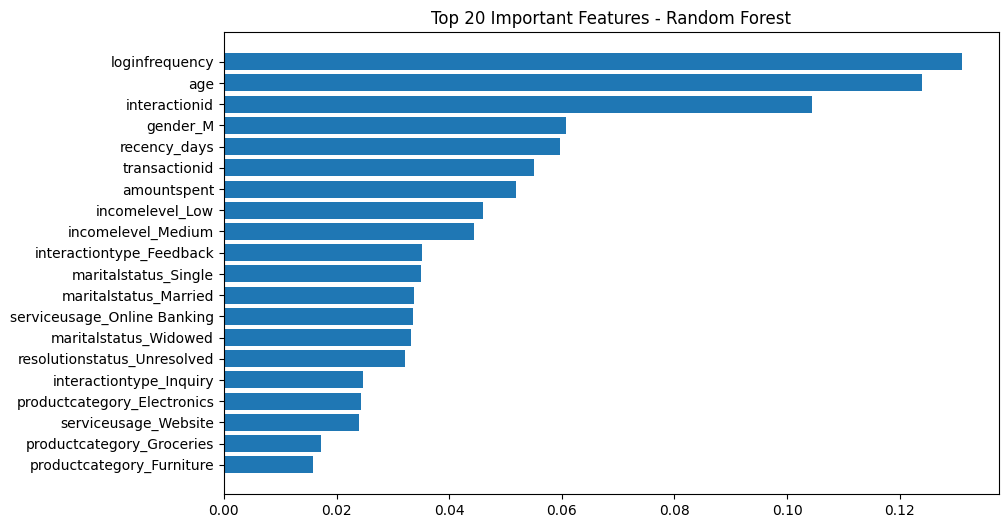

In [31]:
imp_rf = pd.DataFrame({'feature':X_train_numeric.columns,'importance':best_rf.feature_importances_}).sort_values(by='importance',ascending=False)
plt.figure(figsize=(10,6))
plt.barh(imp_rf.head(20)['feature'],imp_rf.head(20)['importance'])
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features - Random Forest")
plt.show()


In [32]:
xgb = XGBClassifier(random_state=42,eval_metric='logloss',use_label_encoder=False)
param_grid_xgb = {'n_estimators':[300,600],'learning_rate':[0.01,0.1],'max_depth':[4,8]}
gs_xgb = GridSearchCV(xgb,param_grid_xgb,cv=StratifiedKFold(n_splits=5),scoring='roc_auc',n_jobs=-1,verbose=1)
gs_xgb.fit(X_res,y_res)
best_xgb = gs_xgb.best_estimator_
joblib.dump(gs_xgb,'xgb_gridsearch.joblib')


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:34:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['xgb_gridsearch.joblib']

In [33]:
xgb_pred = best_xgb.predict(X_test_numeric)
xgb_proba = best_xgb.predict_proba(X_test_numeric)[:,1]
print(classification_report(y_test,xgb_pred))
print("ROC-AUC:",roc_auc_score(y_test,xgb_proba))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1092
           1       0.97      0.89      0.92       271

    accuracy                           0.97      1363
   macro avg       0.97      0.94      0.95      1363
weighted avg       0.97      0.97      0.97      1363

ROC-AUC: 0.9842497600800184


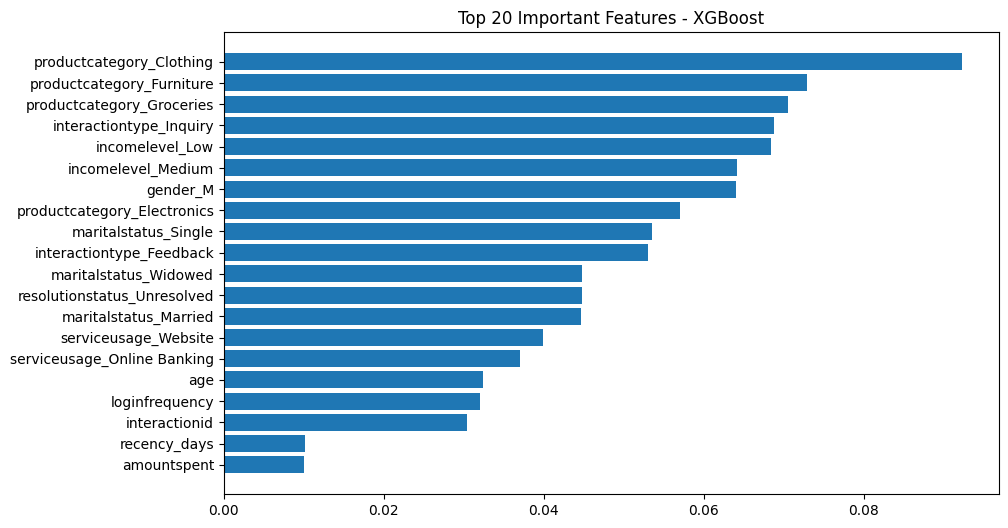

In [34]:
imp_xgb = pd.DataFrame({'feature':X_train_numeric.columns,'importance':best_xgb.feature_importances_}).sort_values(by='importance',ascending=False)
plt.figure(figsize=(10,6))
plt.barh(imp_xgb.head(20)['feature'],imp_xgb.head(20)['importance'])
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features - XGBoost")
plt.show()


In [35]:
ensemble = VotingClassifier(estimators=[('rf',best_rf),('xgb',best_xgb)],voting='soft')
ensemble.fit(X_res,y_res)
ens_pred = ensemble.predict(X_test_numeric)
ens_proba = ensemble.predict_proba(X_test_numeric)[:,1]
print(classification_report(y_test,ens_pred))
print("ROC-AUC:",roc_auc_score(y_test,ens_proba))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:34:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1092
           1       0.95      0.87      0.91       271

    accuracy                           0.97      1363
   macro avg       0.96      0.93      0.94      1363
weighted avg       0.97      0.97      0.96      1363

ROC-AUC: 0.9783227227876675


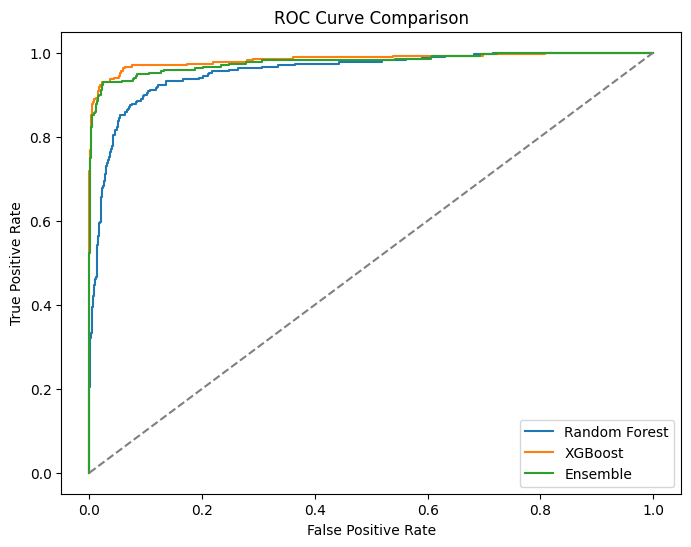

In [36]:
plt.figure(figsize=(8,6))
fpr_rf,tpr_rf,_=roc_curve(y_test,rf_proba)
fpr_xgb,tpr_xgb,_=roc_curve(y_test,xgb_proba)
fpr_ens,tpr_ens,_=roc_curve(y_test,ens_proba)
plt.plot(fpr_rf,tpr_rf,label='Random Forest')
plt.plot(fpr_xgb,tpr_xgb,label='XGBoost')
plt.plot(fpr_ens,tpr_ens,label='Ensemble')
plt.plot([0,1],[0,1],'--',color='gray')
plt.legend()
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


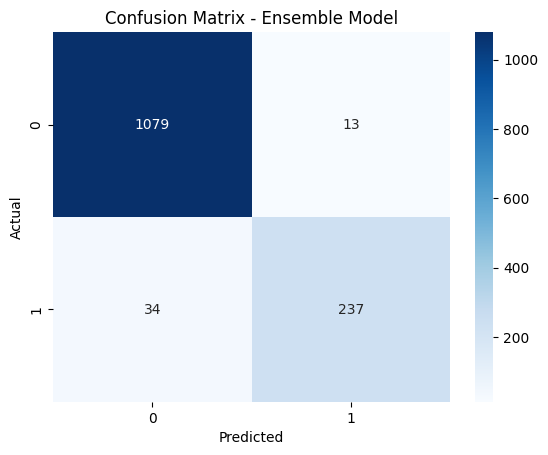

In [37]:
cm = confusion_matrix(y_test,ens_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


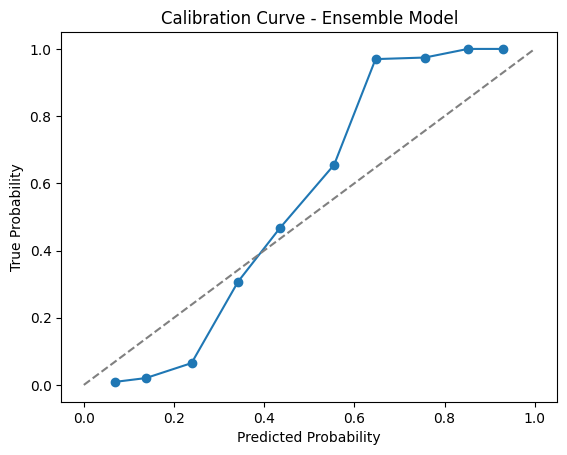

In [38]:
prob_true,prob_pred = calibration_curve(y_test,ens_proba,n_bins=10)
plt.plot(prob_pred,prob_true,marker='o')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Calibration Curve - Ensemble Model")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.show()


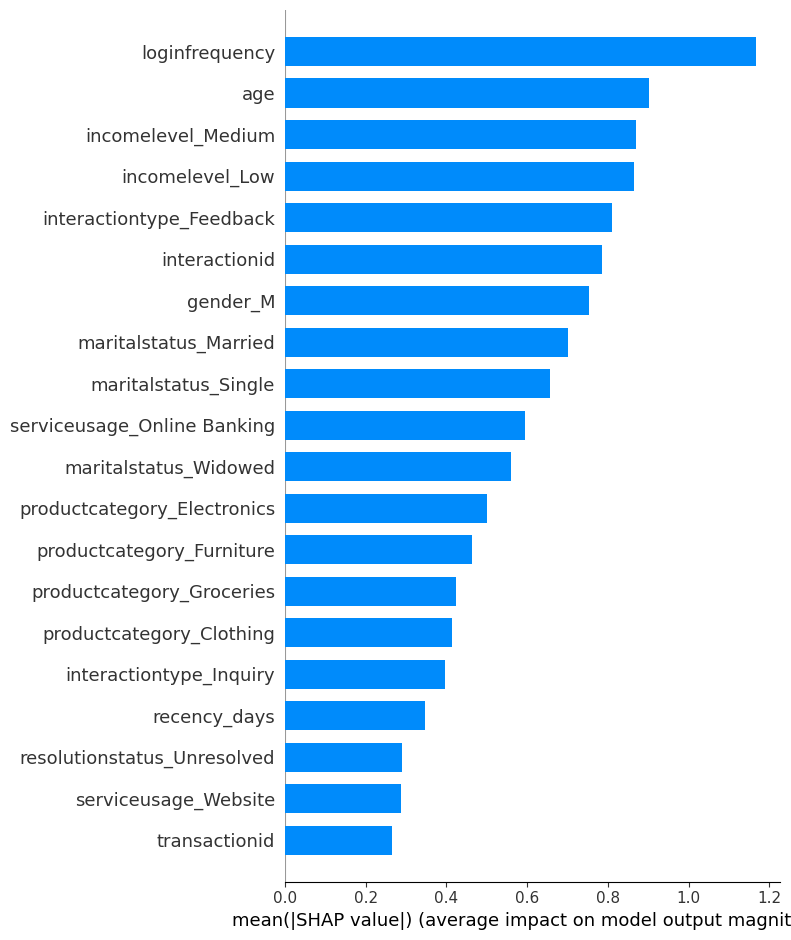

In [39]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test_numeric)
shap.summary_plot(shap_values, X_test_numeric, plot_type="bar")


In [40]:
!pip install -q ppscore

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 54.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2025.10.1 requires pandas>=2.2, but you have pandas 1.5.3 which is incompatible.
arviz 0.22.0 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
dask-cudf-cu12 25.6.0 require

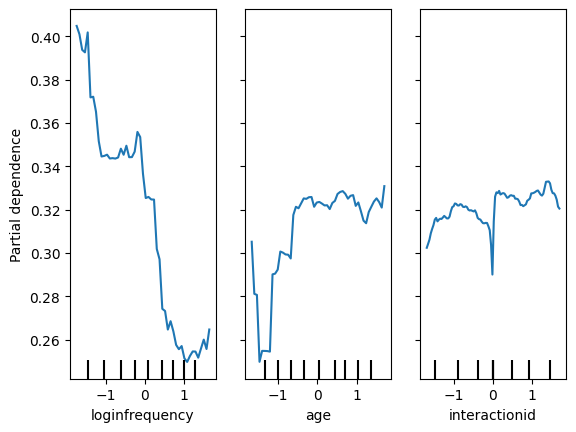

In [41]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(best_rf,X_test_numeric,imp_rf.head(3)['feature'].tolist())
plt.show()

In [42]:
joblib.dump(best_rf,'final_random_forest_model.joblib')
joblib.dump(best_xgb,'final_xgboost_model.joblib')
joblib.dump(ensemble,'final_ensemble_model.joblib')


['final_ensemble_model.joblib']

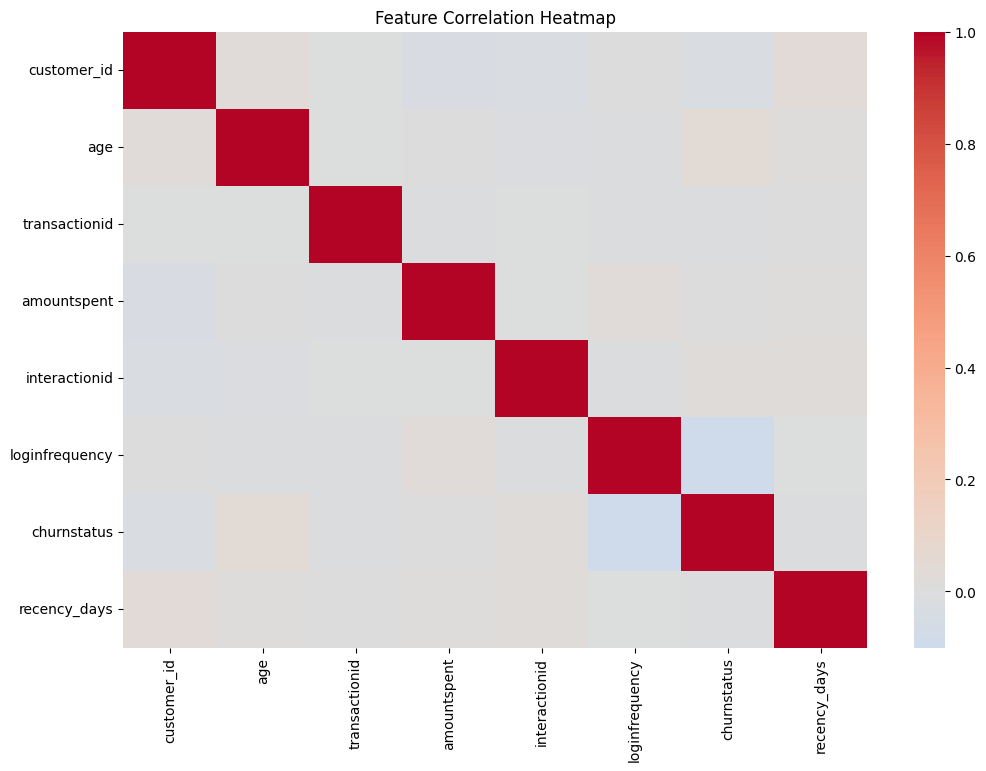

In [43]:
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(),cmap="coolwarm",center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


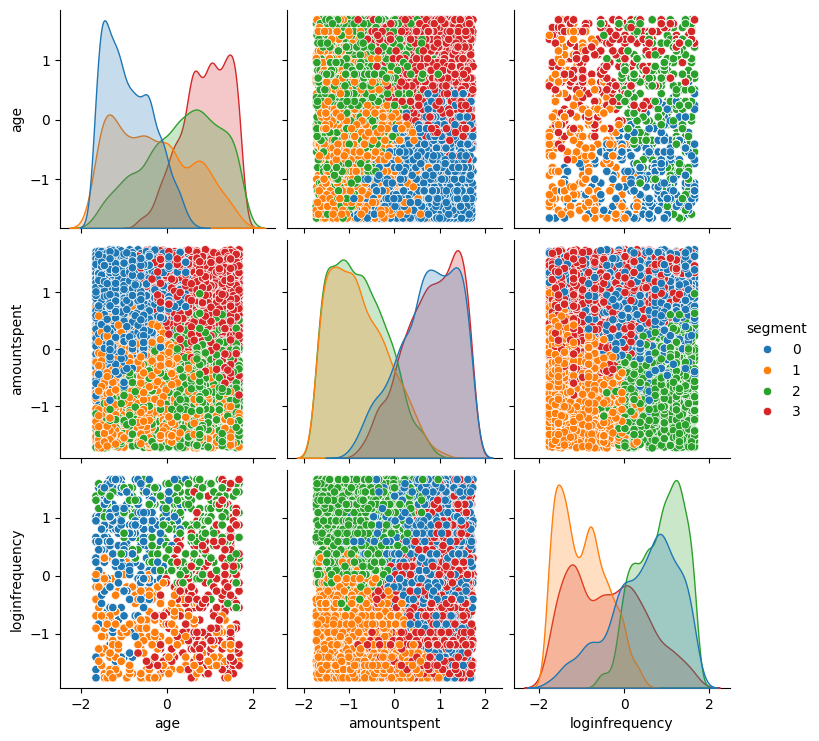

In [44]:
from sklearn.cluster import KMeans
seg_features = ['age','amountspent','loginfrequency']
X_seg = df[seg_features].fillna(df[seg_features].median())
scaler = StandardScaler()
X_seg_scaled = scaler.fit_transform(X_seg)
kmeans = KMeans(n_clusters=4,random_state=42,n_init=20)
df['segment'] = kmeans.fit_predict(X_seg_scaled)
sns.pairplot(df,vars=seg_features,hue='segment',palette='tab10')
plt.show()


In [45]:
seg_summary = df.groupby('segment')[['age','amountspent','loginfrequency']].mean().round(2)
seg_summary['count'] = df['segment'].value_counts()
seg_summary


,age,amountspent,loginfrequency,count
segment,,,,
0,-0.89,0.75,0.45,1746
1,-0.34,-0.79,-0.98,1650
2,0.36,-0.79,0.84,1752
3,0.90,0.83,-0.38,1664


/tmp/ipython-input-3500663157.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_seg,x='segment',y='churn_rate',palette='coolwarm')


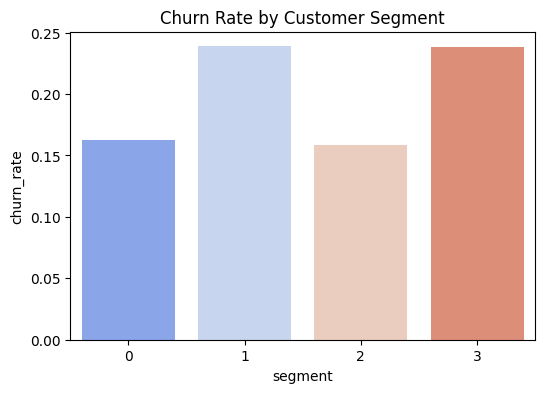

In [46]:
df['churnstatus'] = df['churnstatus'].astype(int)
churn_by_seg = df.groupby('segment')['churnstatus'].mean().reset_index().rename(columns={'churnstatus':'churn_rate'})
plt.figure(figsize=(6,4))
sns.barplot(data=churn_by_seg,x='segment',y='churn_rate',palette='coolwarm')
plt.title("Churn Rate by Customer Segment")
plt.show()


In [47]:
high_risk = df[df['churnstatus']==1]
profile = high_risk[['age','amountspent','loginfrequency']].describe().round(2)
profile


,age,amountspent,loginfrequency
count,1352.00,1352.00,1352.00
mean,0.09,0.01,-0.20
std,0.98,1.01,1.01
min,-1.65,-1.72,-1.76
25%,-0.67,-0.89,-1.19
50%,0.11,0.01,-0.12
75%,0.90,0.91,0.61
max,1.68,1.74,1.66


/tmp/ipython-input-1851573709.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ltv_summary,x='segment',y='avg_ltv',palette='Blues_d')


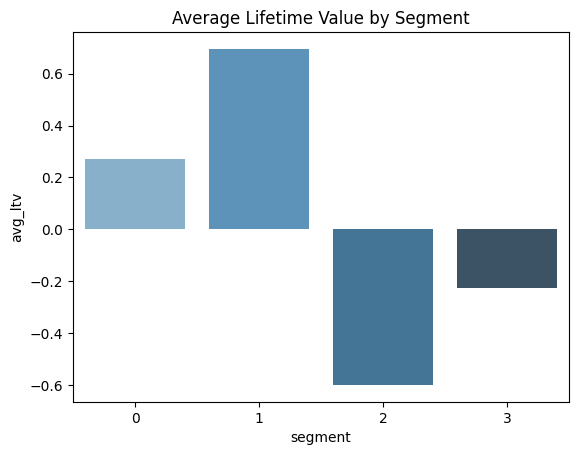

In [48]:
df['ltv'] = df['amountspent'] * df['loginfrequency']
ltv_summary = df.groupby('segment')['ltv'].mean().reset_index().rename(columns={'ltv':'avg_ltv'})
sns.barplot(data=ltv_summary,x='segment',y='avg_ltv',palette='Blues_d')
plt.title("Average Lifetime Value by Segment")
plt.show()


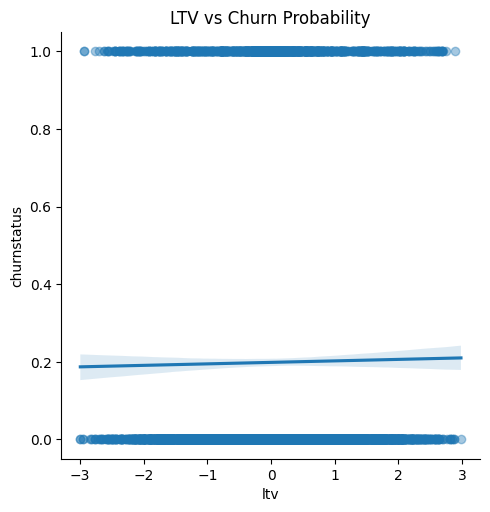

In [49]:
sns.lmplot(data=df,x='ltv',y='churnstatus',scatter_kws={'alpha':0.4})
plt.title("LTV vs Churn Probability")
plt.show()


In [50]:
risk_summary = df.groupby('segment')[['churnstatus','amountspent','loginfrequency']].mean().reset_index()
risk_summary['retention_strategy'] = np.where(risk_summary['churnstatus']>0.3,'Immediate Retention Offer',
                                     np.where(risk_summary['churnstatus']>0.15,'Monitor Closely','Low Risk'))
risk_summary


,segment,churnstatus,amountspent,loginfrequency,retention_strategy
0,0,0.162658,0.745687,0.452795,Monitor Closely
1,1,0.238788,-0.788160,-0.984632,Monitor Closely
2,2,0.158676,-0.788227,0.839542,Monitor Closely
3,3,0.237981,0.829007,-0.382701,Monitor Closely


In [51]:
loyal_customers = df[(df['churnstatus']==0)&(df['ltv']>df['ltv'].quantile(0.75))]
loyal_summary = loyal_customers.groupby('segment')[['amountspent','loginfrequency']].mean().round(2)
loyal_summary


,amountspent,loginfrequency
segment,,
0,1.19,1.09
1,-1.16,-1.21
2,0.08,0.95
3,1.10,0.81


/tmp/ipython-input-351259111.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seg_summary,x=seg_summary.index,y='amountspent',ax=ax[0],palette='viridis')
/tmp/ipython-input-351259111.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_seg,x='segment',y='churn_rate',ax=ax[1],palette='Reds')


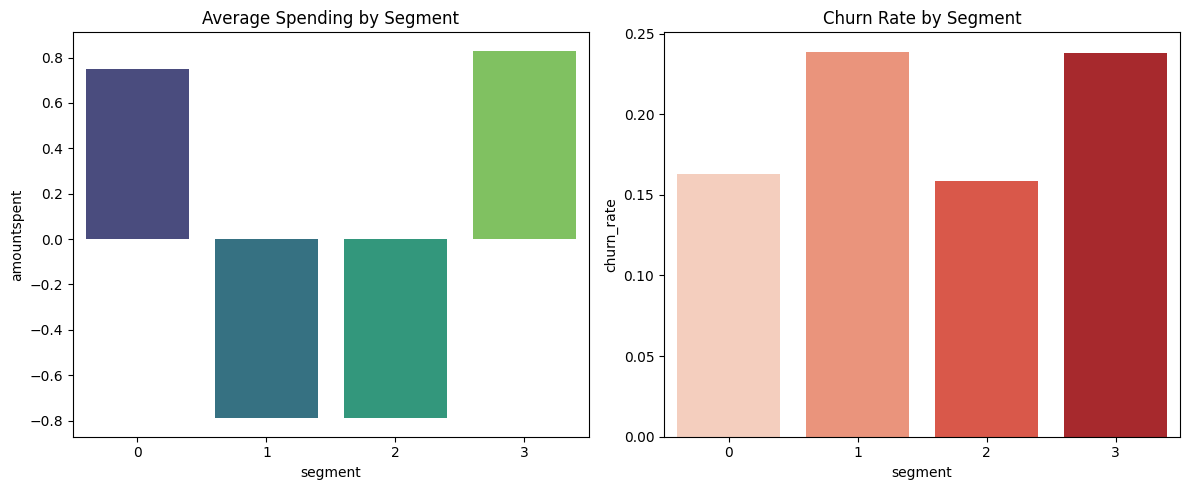

In [52]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(data=seg_summary,x=seg_summary.index,y='amountspent',ax=ax[0],palette='viridis')
sns.barplot(data=churn_by_seg,x='segment',y='churn_rate',ax=ax[1],palette='Reds')
ax[0].set_title("Average Spending by Segment")
ax[1].set_title("Churn Rate by Segment")
plt.tight_layout()
plt.show()


In [53]:

!pip install -q flask flask-cors pyngrok


In [54]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import joblib
import pandas as pd
import numpy as np

app = Flask(__name__)
CORS(app)

model = joblib.load('final_ensemble_model.joblib')
scaler = joblib.load('scaler.joblib') if os.path.exists('scaler.joblib') else None
datetime_cols = list(datetime_cols) if 'datetime_cols' in globals() else []
model_features = getattr(model, "feature_names_in_", None)
if model_features is None and 'X_train_numeric' in globals():
    model_features = X_train_numeric.columns.values
model_features = list(model_features)

@app.route('/predict', methods=['POST'])
def predict():
    payload = request.get_json(force=True)
    df_in = pd.DataFrame(payload if isinstance(payload, list) else [payload])
    for c in datetime_cols:
        if c in df_in.columns:
            df_in = df_in.drop(columns=[c])
    for col in model_features:
        if col not in df_in.columns:
            df_in[col] = 0
    df_in = df_in[model_features].astype(float)
    if scaler is not None:
        df_in = pd.DataFrame(scaler.transform(df_in), columns=model_features)
    probs = model.predict_proba(df_in)[:,1]
    preds = (probs >= 0.5).astype(int)
    return jsonify({'predictions': preds.tolist(), 'probabilities': probs.tolist()})

print("✅ Flask API is ready. Run the next cell to test it locally.")


✅ Flask API is ready. Run the next cell to test it locally.


In [55]:
sample = {
    "age": 32,
    "amountspent": 310.5,
    "loginfrequency": 18
}

# Ensure model_features is correctly capturing the feature names from the training data
if 'X_train_numeric' in globals():
    model_features = X_train_numeric.columns.tolist()
elif hasattr(model, "feature_names_in_"):
    model_features = model.feature_names_in_.tolist()
else:
    raise ValueError("Could not determine model feature names.")


# Create a DataFrame with all expected model features, initialized to 0
test_df = pd.DataFrame(0.0, index=[0], columns=model_features)

# Populate the DataFrame with sample data for the relevant features
for col, value in sample.items():
    if col in test_df.columns:
        test_df[col] = value
    else:
        print(f"Warning: Feature '{col}' from sample is not in model features.")


# Check if the scaler exists and apply it to the relevant numeric columns
if scaler is not None:
    # Identify numeric columns within the model_features that were scaled
    num_features_to_scale_in_model = [col for col in model_features if col in num_features_to_scale]
    test_df[num_features_to_scale_in_model] = scaler.transform(test_df[num_features_to_scale_in_model])


# Make predictions
proba = model.predict_proba(test_df)[:, 1][0]
pred = int(proba >= 0.5)

print("Predicted churn probability:", round(proba, 3))
print("Churn prediction (1 = churn, 0 = retain):", pred)

Predicted churn probability: 0.125
Churn prediction (1 = churn, 0 = retain): 0


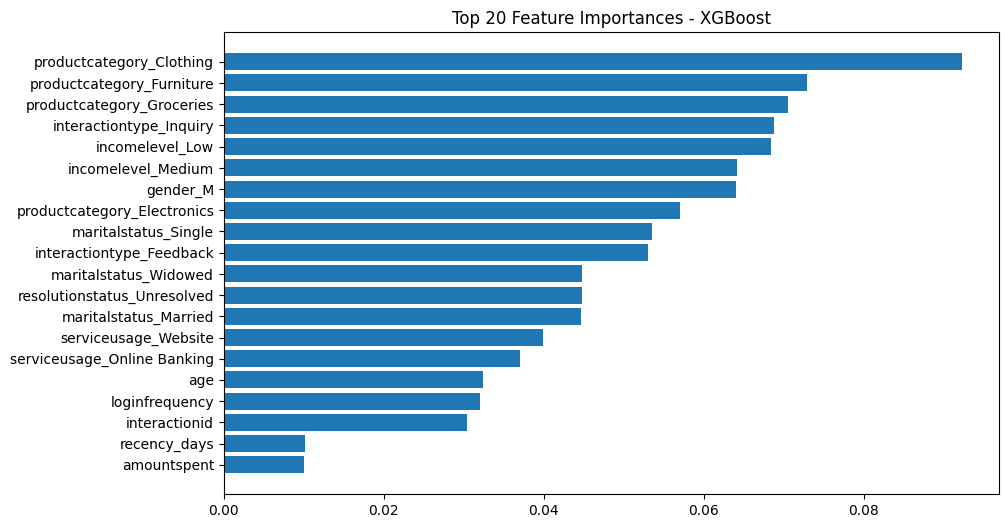

In [56]:
import matplotlib.pyplot as plt
imp = pd.DataFrame({'feature':X_train_numeric.columns,'importance':best_xgb.feature_importances_}).sort_values('importance',ascending=False)
plt.figure(figsize=(10,6))
plt.barh(imp.head(20)['feature'],imp.head(20)['importance'])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances - XGBoost")
plt.show()


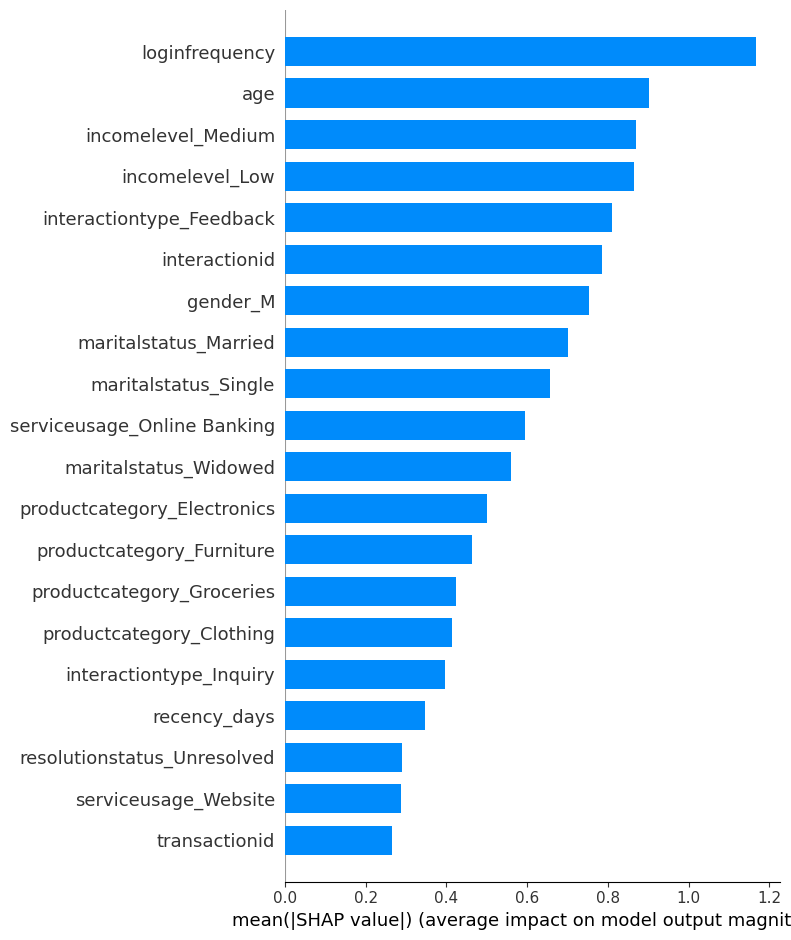

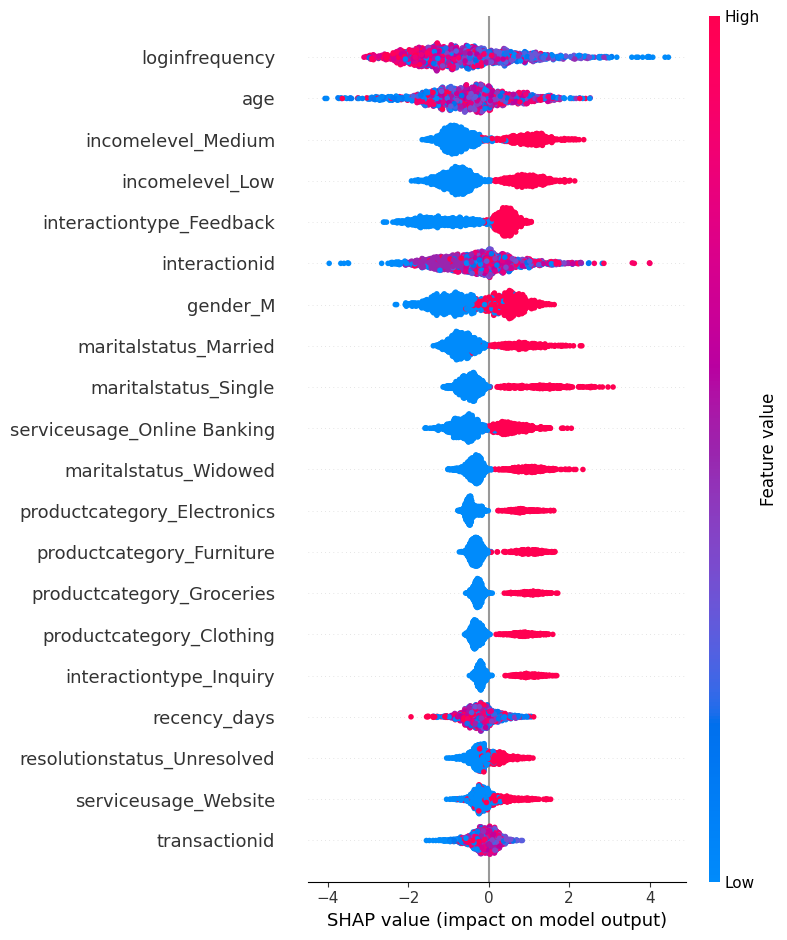

In [57]:
import shap
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test_numeric)
shap.summary_plot(shap_values, X_test_numeric, plot_type="bar")
shap.summary_plot(shap_values, X_test_numeric)


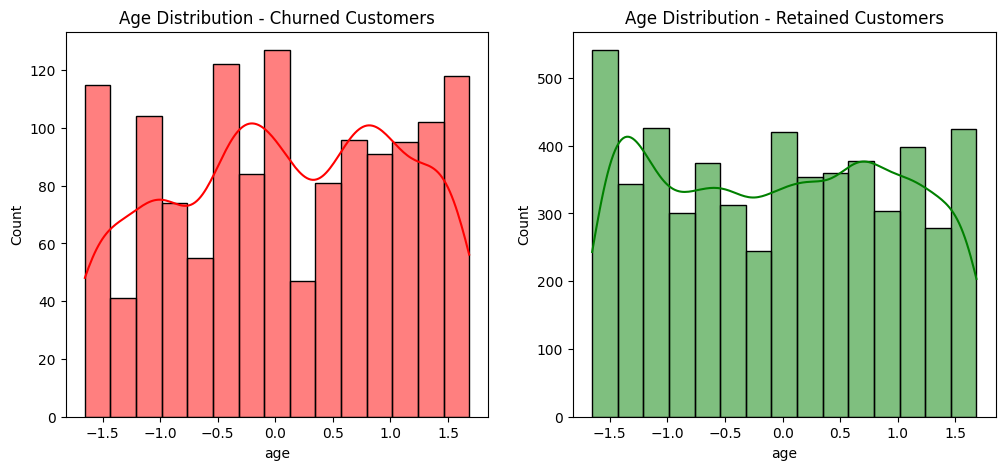

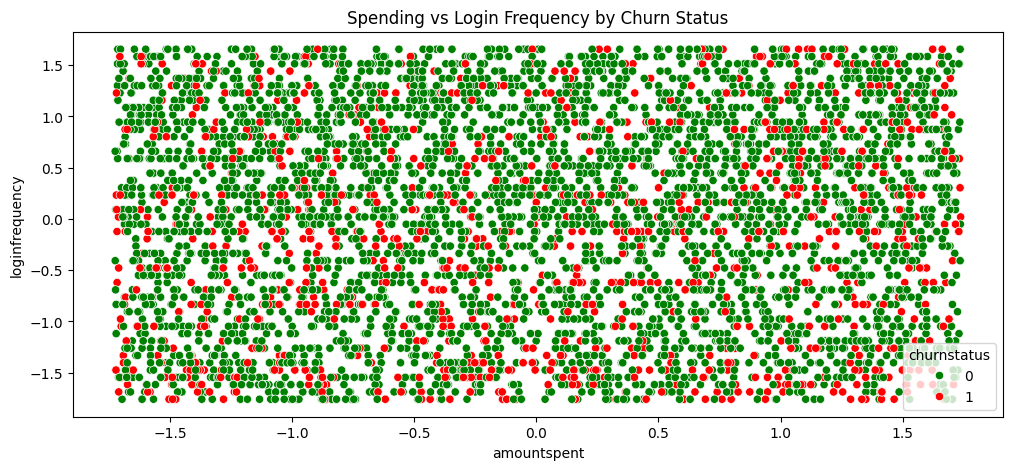

In [58]:
import seaborn as sns
df['churnstatus'] = df['churnstatus'].astype(int)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df[df['churnstatus']==1]['age'], bins=15, kde=True, color='red')
plt.title("Age Distribution - Churned Customers")
plt.subplot(1,2,2)
sns.histplot(df[df['churnstatus']==0]['age'], bins=15, kde=True, color='green')
plt.title("Age Distribution - Retained Customers")
plt.show()

plt.figure(figsize=(12,5))
sns.scatterplot(data=df,x='amountspent',y='loginfrequency',hue='churnstatus',palette=['green','red'])
plt.title("Spending vs Login Frequency by Churn Status")
plt.show()


In [59]:
risk_df = df.groupby('segment')[['churnstatus','amountspent','loginfrequency']].mean().reset_index()
risk_df['strategy'] = risk_df['churnstatus'].apply(lambda x: 'Immediate Retention Offer' if x>0.3 else ('Monitor Closely' if x>0.15 else 'Low Risk'))
risk_df


,segment,churnstatus,amountspent,loginfrequency,strategy
0,0,0.162658,0.745687,0.452795,Monitor Closely
1,1,0.238788,-0.788160,-0.984632,Monitor Closely
2,2,0.158676,-0.788227,0.839542,Monitor Closely
3,3,0.237981,0.829007,-0.382701,Monitor Closely
